# GRM project - Graph-cut style transfer

Antoine Debouchage, Gaspard Berthelier, Thomas Lemercier

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import copy

import numpy as np

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/GRM_proj/

Mounted at /content/drive/
/content/drive/My Drive/GRM_proj


## Images

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128

In [4]:
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
# style_img = image_loader("../data/images/kawase.png")[:, :3]
# # style_img = image_loader("../data/images/monnet.png")[:, :3]
# content_img = image_loader("../data/images/dance2.png")[:, :3]

style_img = image_loader("data/images/kawase.png")[:, :3]
content_img = image_loader("data/images/dance2.png")[:, :3]

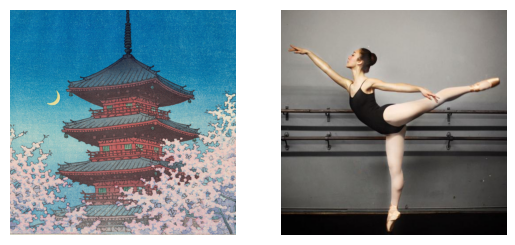

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(style_img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(content_img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Model

In [7]:
model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 139MB/s]


In [8]:
style_img.shape, content_img.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1).to(device)
        self.std = std.clone().detach().view(-1, 1, 1).to(device)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [10]:
pipeline = nn.Sequential()
pipeline.add_module('normalization', Normalization(cnn_normalization_mean, cnn_normalization_std))
for i in range(0, 29):#29):
    pipeline.add_module('layer_{}'.format(i), model[i])
pipeline = pipeline.to(device)

In [11]:
pipeline

Sequential(
  (normalization): Normalization()
  (layer_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_1): ReLU(inplace=True)
  (layer_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_3): ReLU(inplace=True)
  (layer_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_6): ReLU(inplace=True)
  (layer_7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_8): ReLU(inplace=True)
  (layer_9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_11): ReLU(inplace=True)
  (layer_12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_13): ReLU(inplace=True)
  (layer_14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_15): ReLU(

We get the VGG4-1 layer at the end

In [12]:
(style_img).shape

torch.Size([1, 3, 512, 512])

In [13]:
features = pipeline(style_img)

In [14]:
features.shape

torch.Size([1, 512, 32, 32])

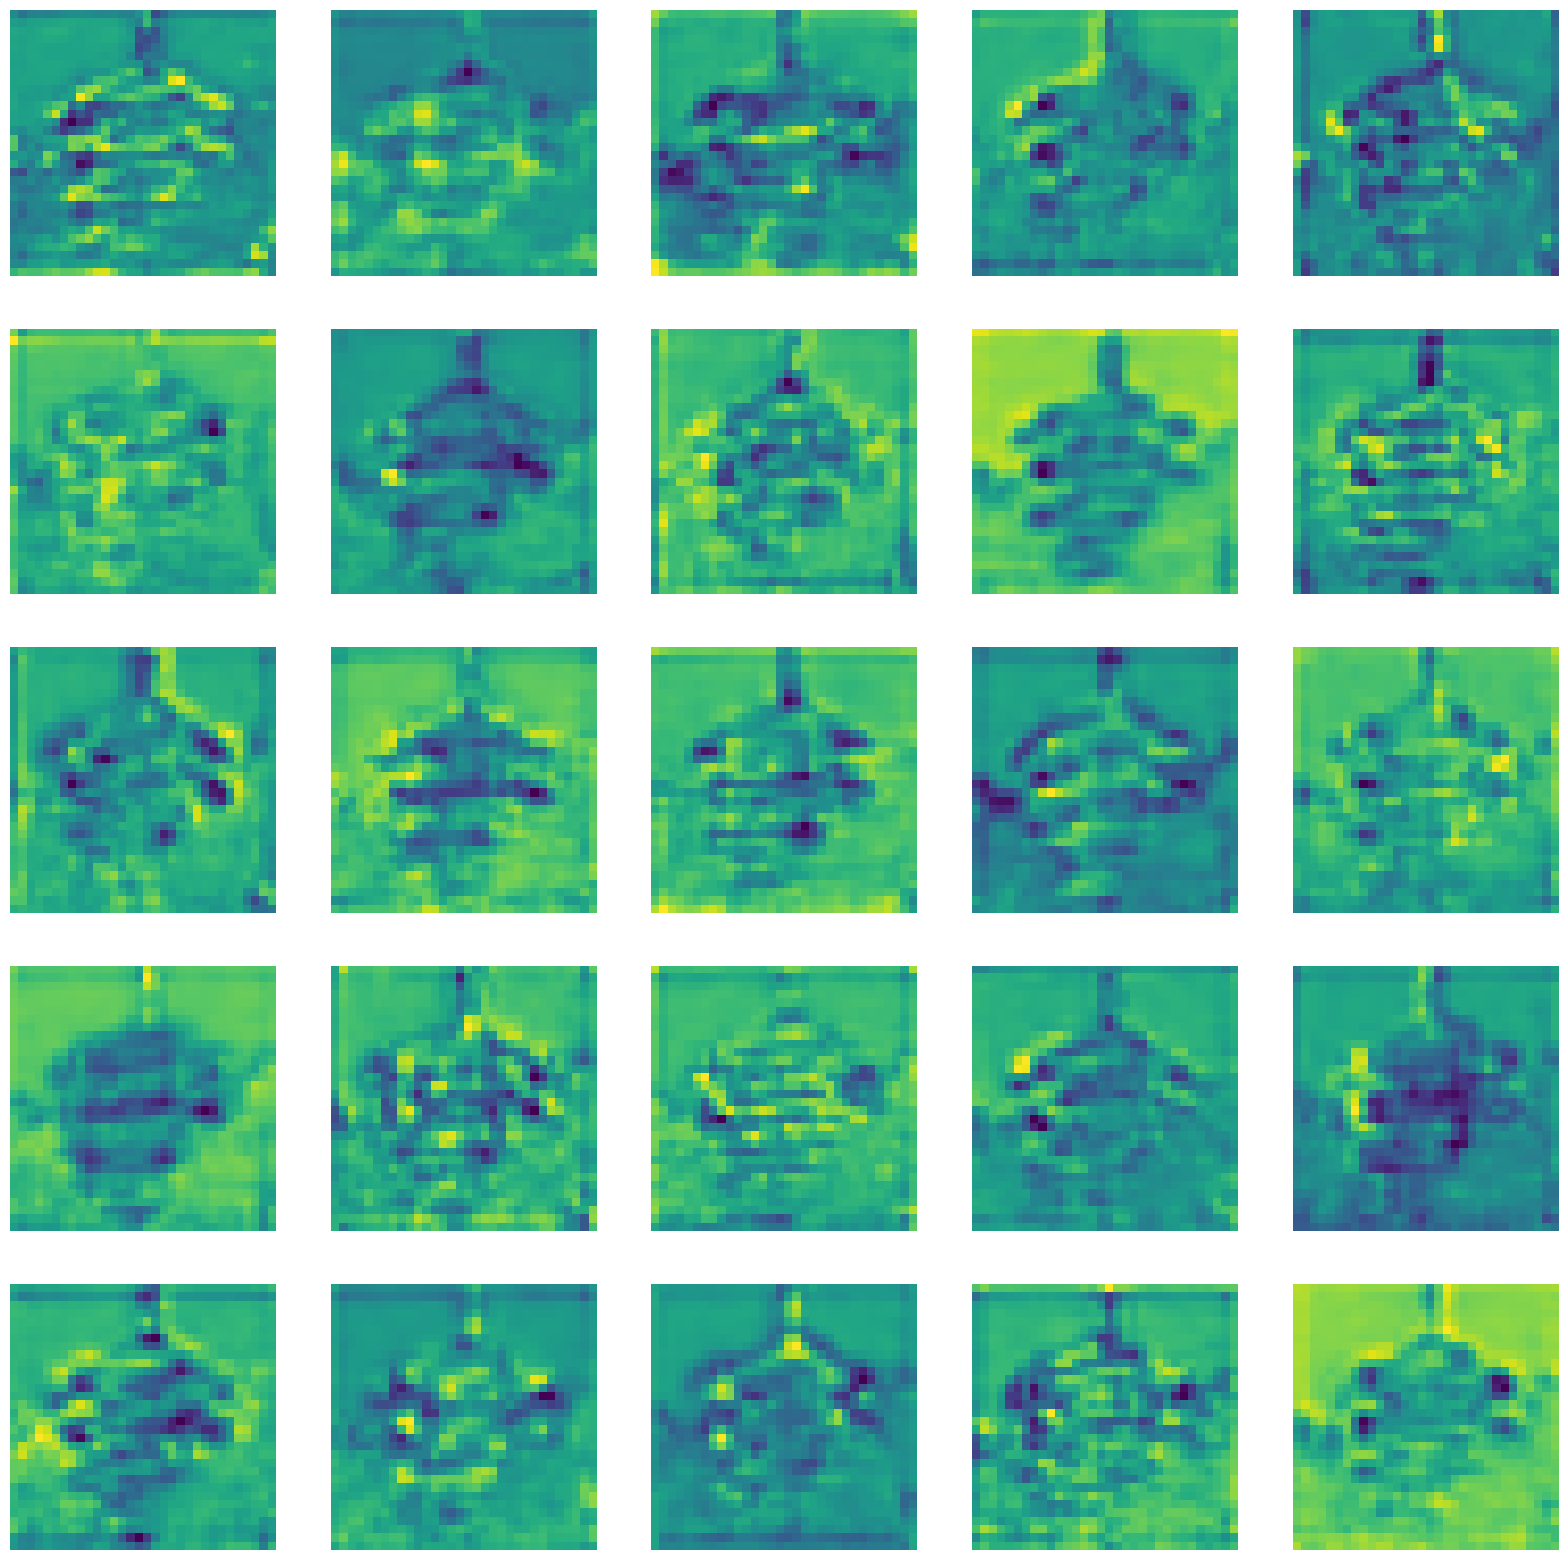

In [15]:
# Plot grid of the 25 first features
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(features[0, i].cpu().detach().numpy())
    plt.axis('off')

## Clustering

(512, 1024)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.003s...
[t-SNE] Computed neighbors for 1024 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 10.995397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 14.182513
[t-SNE] KL divergence after 1000 iterations: 0.587628


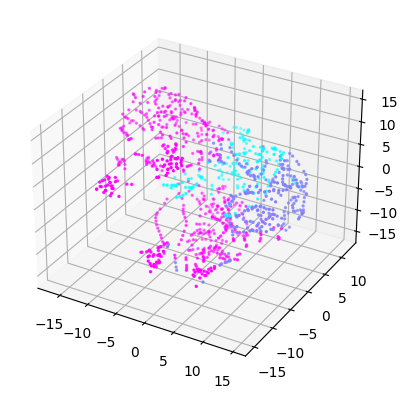

In [16]:
#Make a clustering of the features into K = 3 clusters then visualize the clusters with tSNE

do_tsne = True
if do_tsne:
  features_view = features.view(features.shape[1], -1).cpu().detach().numpy()
  print(features_view.shape)
  kmeans = KMeans(n_clusters=3, random_state=0).fit(features_view.T)

  features_embedded = TSNE(n_components=3, n_jobs=4, verbose=1, early_exaggeration=4).fit_transform(features_view.T)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(features_embedded[:, 0], features_embedded[:, 1], features_embedded[:, 2], c=kmeans.labels_, cmap='cool', s=2)
  plt.show()

do_save = False
if do_save:
  np.save("../data/misc/features_embedded2.npy", features_embedded)
  np.save("../data/misc/kmeans2.npy", kmeans.labels_)

## Implementation

In [19]:
# !pip install PyMaxflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 9.8 MB/s eta 0:00:00


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from maxflow.fastmin import aexpansion_grid

colormap = plt.cm.plasma

def cluster_style(style_features, k=3, plot=False):
    style_features_view = style_features.reshape(style_features.shape[0], -1).T # (channel, height * width)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(style_features_view)

    if plot:
        plt.imshow(kmeans.labels_.reshape(style_features.shape[1], style_features.shape[2]), cmap=colormap)
        plt.axis('off')
        plt.show()

    cluster_centers = kmeans.cluster_centers_ # (k, channel)
    cluster_list = [style_features_view[kmeans.labels_ == i] for i in range(k)]
    return cluster_centers, cluster_list

def data_energy(content_features, cluster_centers):
    content_shape = content_features.shape
    content_features = content_features.reshape(content_shape[0], -1).T

    similarity = cosine_similarity(content_features, cluster_centers)
    similarity = similarity.reshape(content_shape[1], content_shape[2], -1)

    return 1 - similarity

def smooth_energy(cluster_centers, gamma):
    k = cluster_centers.shape[0]
    return gamma * (1 - np.eye(k))


def total_energy(content_features, style_features, k=2,  gamma=0.1, plot=False):
    cluster_centers, cluster_list = cluster_style(style_features, k=k, plot=plot)

    data_term = data_energy(content_features, cluster_centers) # (height, width, k)
    smooth_term = smooth_energy(cluster_centers, gamma) # (k, k)

    data_term = data_term.astype(np.double)
    smooth_term = smooth_term.astype(np.double)

    # print(data_term.shape)
    # print(smooth_term)

    labels = aexpansion_grid(data_term, smooth_term, max_cycles=None)
    # print(labels.shape)
    # print(labels)

    if plot:
        plt.figure(figsize=(20, 20))
        for i in range(k):
            plt.subplot(1, k, i+1)
            plt.imshow(data_term[:, :, i])
            plt.axis('off')
        plt.show()

        plt.imshow(labels, cmap=colormap)
        plt.axis('off')
        plt.show()

    return labels, cluster_list

In [21]:
content_features = pipeline(content_img)[0] # (batch, channel, height, width)
style_features = pipeline(style_img)[0] # (batch, channel, height, width)

content_features = content_features.cpu().detach().numpy()
style_features = style_features.cpu().detach().numpy()

content_features.shape, style_features.shape

((512, 32, 32), (512, 32, 32))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


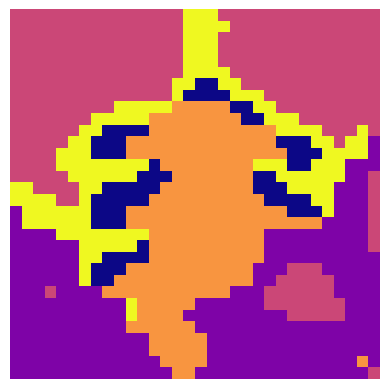

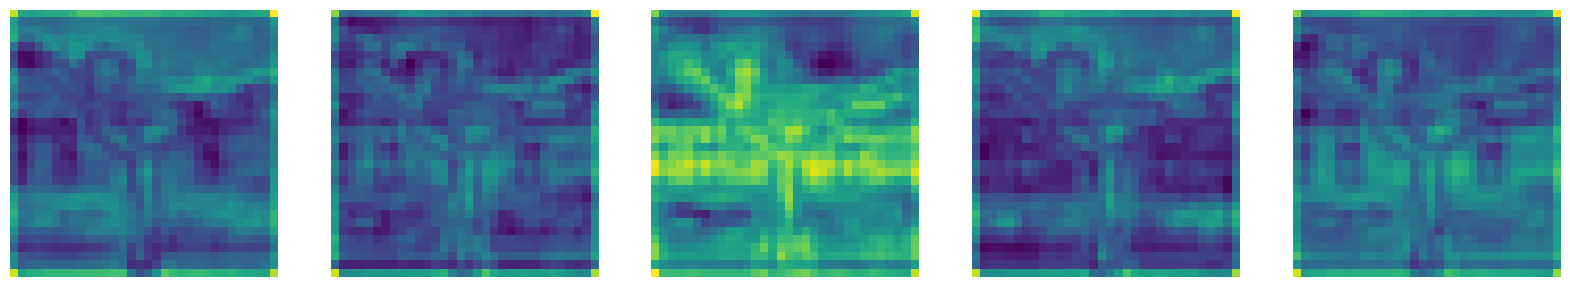

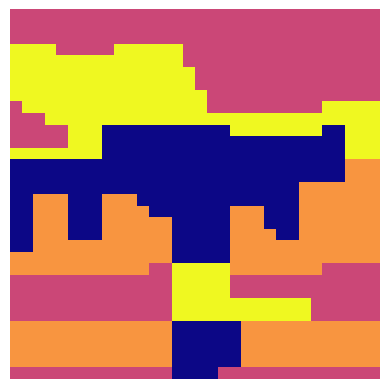

In [22]:
labels, style_clusters = total_energy(content_features, style_features, k=5, gamma=0.05, plot=True)

In [25]:
style_clusters[0].shape, style_clusters[1].shape, style_clusters[2].shape, style_clusters[3].shape, style_clusters[4].shape

((70, 512), (283, 512), (324, 512), (211, 512), (136, 512))

In [26]:
label = (labels == 0)[np.newaxis, :, :].repeat(content_features.shape[0], axis=0).astype(np.float32)
label.shape, content_features.shape

((512, 32, 32), (512, 32, 32))

In [30]:
total_energy(style_img, style_img, k=5, gamma=0.05, plot=True)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [27]:
def feature_whitening(content_features, style_features, label, alpha):
    channels = content_features.shape[0]
    cluster_size = style_features.shape[0]

    # Compute the mean of the content features
    # Multiply each channel by the label to put to zero the non-content features
    content_mask = content_features * label # (channel, height, width)
    content_mean = np.mean(content_mask, axis=(1, 2), keepdims=True) * label
    content_features = content_features - content_mean
    content_covariance = np.einsum('ijk,ljk->il', content_features, content_features) / (sum(label.flatten()) / channels - 1)

    # Compute the mean of the style features
    # Multiply each channel by the label to put to zero the non-content features
    style_features = style_features.T # (height * width, cluster size)
    style_mean = np.mean(style_features, axis=(1, ), keepdims=True)
    style_features = style_features - style_mean
    style_covariance = np.einsum('ij,lj->il', style_features, style_features) / (cluster_size - 1)

    content_U, content_S, content_V = np.linalg.svd(content_covariance)
    style_U, style_S, style_V = np.linalg.svd(style_covariance)
    content_D = np.diag(np.power(content_S, -0.5))
    style_D = np.diag(np.power(style_S, 0.5))

    whitening_matrix = content_V @ content_D @ content_V.T
    coloring_matrix = style_V @ style_D @ style_V.T

    print(style_mean.shape)
    print(style_features.shape)
    style_mean = style_mean[:, np.newaxis]
    print(style_mean.shape)
    style_mean = style_mean * label
    print(style_mean.shape)
    print(coloring_matrix.shape, whitening_matrix.shape, content_features.shape, style_mean.shape)

    result = (coloring_matrix @ whitening_matrix @ content_features.reshape(channels, -1)).reshape(content_features.shape) + style_mean
    result = result * (1 - alpha) + content_features * alpha

    return result

In [28]:
# for each cluster, whitening and coloring

transfer_style_features = np.zeros_like(content_features)
for k, style_cluster in enumerate(style_clusters):
    label = (labels == k)[np.newaxis, :, :].repeat(content_features.shape[0], axis=0).astype(np.float32) # (channel, height, width)
    transfer_style_features += feature_whitening(content_features, style_cluster, label, alpha=0.5)

(512, 1)
(512, 70)
(512, 1, 1)
(512, 32, 32)
(512, 512) (512, 512) (512, 32, 32) (512, 32, 32)
(512, 1)
(512, 283)
(512, 1, 1)
(512, 32, 32)
(512, 512) (512, 512) (512, 32, 32) (512, 32, 32)
(512, 1)
(512, 324)
(512, 1, 1)
(512, 32, 32)
(512, 512) (512, 512) (512, 32, 32) (512, 32, 32)
(512, 1)
(512, 211)
(512, 1, 1)
(512, 32, 32)
(512, 512) (512, 512) (512, 32, 32) (512, 32, 32)
(512, 1)
(512, 136)
(512, 1, 1)
(512, 32, 32)
(512, 512) (512, 512) (512, 32, 32) (512, 32, 32)


In [29]:
transfer_style_features.shape

(512, 32, 32)